In [1]:
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
import pytz
import os

In [2]:
import risk_model
import factorize
import account

In [3]:
availabe_accounts = pd.read_csv('account_ids.txt',header=None)
print (availabe_accounts.values)

[['DU1440139']
 ['U2909804']]


In [4]:
account_number = availabe_accounts.values[0][0]

In [5]:
rth = True

In [6]:
if account_number == availabe_accounts.values[1][0]:

    optimal_weights_regularized = pd.read_csv('data/optimal_weights_regularized_sa.csv',index_col = 'asset')
    close = pd.read_csv('data/close_sa.csv', index_col = 'date')
    
elif account_number == availabe_accounts.values[0][0]:
    
    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized.csv',index_col = 'asset')
    close = pd.read_csv('data/close.csv', index_col = 'date')

# 1 - Portfolio Management

In [7]:
portfolio = account.read_positions(subscribe = True, acctCode = account_number)

PositionEnd
Reading Portfolio


In [8]:
acc = account.read_account(reqId = 0, subscribe = True, acctCode = account_number)

AccountDownloadEnd. Account: DU1440139
Reading Account


In [9]:
all_weights, long, short, grv = risk_model.portfolio_calculation(portfolio)

In [10]:
long_value = long['marketValue'].sum()
short_value = short['marketValue'].sum()
#print ('Buying Power: {} $'.format(np.round(float(acc.loc['BuyingPower',:].values[0]), 4)))
print ('Gross Market Value: {} $'.format(np.round(grv, 4)))
print (' Long Value: {} $'.format(np.round(long_value,4)))
print (' Short Value: {} $'.format(np.round(short_value,4)))
print (' Net Liquidation: {} $'.format(np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)))
print (' Unrealize PNL: {} $'.format(np.round(portfolio['unrealizedPNL'].sum()),4))
print (' Loan Value: {} $'.format(np.round(float(acc.loc['GrossPositionValue'][0]) - float(acc.loc['EquityWithLoanValue'][0]), 4)))
print ('#####################################')
print ('Leverage Value: {}'.format(np.round(grv/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Long Leverage Value: {}'.format(np.round(long_value/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Short Leverage Value: {}'.format(np.round(np.abs(short_value)/float(acc.loc['EquityWithLoanValue'][0]), 4)))       

Gross Market Value: 229165.09 $
 Long Value: 138350.7 $
 Short Value: -90814.39 $
 Net Liquidation: 153625.0 $
 Unrealize PNL: -1303.0 $
 Loan Value: 75540.0 $
#####################################
Leverage Value: 1.4917
 Long Leverage Value: 0.9006
 Short Leverage Value: 0.5911


In [11]:
universe = portfolio.index
long_universe = long.index 
short_universe = short.index 

In [12]:
net_liq = np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)

## Projected portfolio balance

In [13]:
target_leverage = 1.5
grv_target = net_liq * target_leverage
excess_grv = grv_target - grv
print (excess_grv,'$')
marketVal_target = all_weights * grv_target

1272.4100000000326 $


In [14]:
balancing_order = marketVal_target['weights'] - portfolio['marketValue']
df_port = portfolio['marketPrice']
action_balance = pd.DataFrame(index = df_port.index, columns = ['shares'])
action_balance['shares'] = np.round(balancing_order / df_port,2)
to_drop = action_balance[action_balance['shares']==0.0].index
action_balance.drop(to_drop,axis=0,inplace=True)

In [15]:
grv_target

230437.5

In [16]:
val = account.read_nextvalidid(reqId=-1)

NextValidId: 1403


## Filtering stocks with significant market value

In [17]:
df_c = pd.DataFrame(data=close[optimal_weights_regularized.index].iloc[-1].values,
                   index = close[optimal_weights_regularized.index].iloc[-1].index,
                   columns = ['close'])
df_c.index.name = 'asset'

In [18]:
#optimal_weights_regularized = optimal_weights_regularized.round(2)

In [19]:
# dropping securities with less than 1% allocation 
#optimal_selected = optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] != 0.00]

In [20]:
# print ('##########################################################')
# print ('dropping {} securities which have less than 1% allocation'.format(len(optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] == 0.00].index)))
# print ('##########################################################')

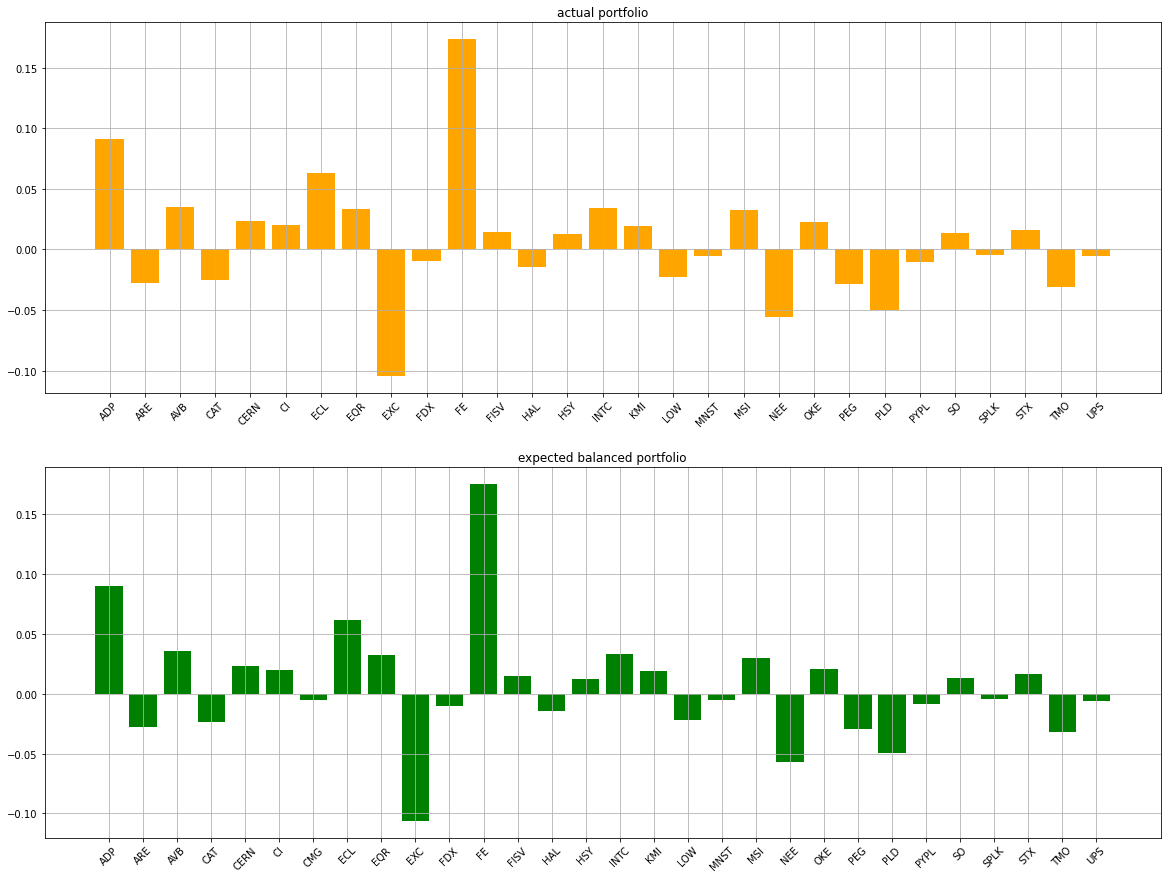

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

x1 = all_weights.index
y1 = all_weights.values.flatten()
axs[0].grid(True)
axs[0].bar(x1, y1, width = 0.8, linewidth = 1, color='orange')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[0].set_title('actual portfolio')

x2 = optimal_weights_regularized.index
y2 = optimal_weights_regularized.values.flatten()
axs[1].grid(True,)
axs[1].bar(x2, y2, width = 0.8, linewidth = 1, color='green')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
axs[1].set_title('expected balanced portfolio')
plt.show()

## Processing data for execution

In [22]:
stock_to_balance = portfolio.index & optimal_weights_regularized.index
stock_to_close = portfolio.index ^ stock_to_balance

In [23]:
df_c_target = df_c.reindex(optimal_weights_regularized.index)
shares_target_float = (optimal_weights_regularized * grv_target)['optimal_weights']/df_c_target['close']

In [24]:
portfolio_shares_float = portfolio['marketValue'] / portfolio['marketPrice']

In [25]:
# Rebalance to optimal weights
action_final = pd.DataFrame(index = shares_target_float.index, columns = ['shares'])

for i in shares_target_float.index:
    
    if (i in stock_to_balance) and (i not in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - portfolio_shares_float[i]
        
    elif (i in stock_to_balance) and (i in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - (portfolio_shares_float[i] + action_balance['shares'][i])

    elif (i in action_balance.index) and (i not in stock_to_balance):
        action_final.loc[i,'shares'] = shares_target_float[i] + action_balance['shares'][i]
    else:
        action_final.loc[i,'shares'] = shares_target_float[i]

In [26]:
# rename columns
portfolio_shares_float = pd.DataFrame(portfolio_shares_float,columns = ['portfolio_shares'],index=portfolio_shares_float.index)
shares_target_float = pd.DataFrame(shares_target_float,columns = ['target_shares_not_balanced'],index=shares_target_float.index)

action_balance.columns = ['balance_lev_shares']
action_final.columns = ['final_action_shares']

In [27]:
# replacing too small actions value with nan value
treshold_long = 1
treshold_short = -1

action_final[(action_final['final_action_shares']>0) & (action_final['final_action_shares']< treshold_long)] = np.nan
action_final[(action_final['final_action_shares']<0) & (action_final['final_action_shares']> treshold_short)] = np.nan
action_final[action_final['final_action_shares']==0.0] = np.nan
action_final.dropna(axis=0,inplace=True)
action_final['final_action_shares'] = pd.to_numeric(action_final['final_action_shares'], errors='coerce')

In [28]:
len(action_final)

10

In [29]:
action_conc = pd.concat([portfolio_shares_float,
                         action_balance,
                         shares_target_float,
                         action_final],axis=1)

In [30]:
isna_df = action_conc.isna()
for i in action_conc.index:
    if (isna_df.loc[i]['final_action_shares'] == True) & (isna_df.loc[i]['target_shares_not_balanced'] == False) :
        action_conc.drop(i, inplace = True)

In [31]:
action_conc.round(2)

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares
ADP,152.0,0.90,151.83,-1.07
CAT,-43.0,-0.18,-40.61,2.57
EXC,-633.0,-3.45,-631.20,5.25
FE,1368.0,7.94,1364.67,-11.27
INTC,158.0,1.06,157.95,-1.11
KMI,303.0,2.33,302.56,-2.77
LOW,-35.0,-0.26,-34.12,1.14
MSI,54.0,0.31,50.09,-4.22
OKE,172.0,0.89,165.98,-6.91
PYPL,-12.0,-0.01,-9.72,2.29


## Executing on TWS

In [32]:
op = account.cancel_openorders()

open order ended


In [33]:
# closing positions not in shares target
if not stock_to_close.empty:
    next_order_id = account.closing_positions(stock_to_close = stock_to_close,
                                              portfolio = portfolio , 
                                              order_id = val)
else:
    print ('There is no stock to close...')
    next_order_id = val

app is running ...
closing 24 positions which are not present in action
closing position for ANSS is: 104 
closing position for AXP is: 108 
closing position for BURL is: 22 
closing position for CHGG is: 38 
closing position for DLR is: 32 
closing position for DTE is: 36 
closing position for ENPH is: 13 
closing position for ETFC is: 148 
closing position for GIS is: 121 
closing position for GS is: 49 
closing position for HCA is: 42 
closing position for IBM is: 79 
closing position for ILMN is: 16 
closing position for KO is: 130 
closing position for MDLZ is: 198 
closing position for MS is: 35 
closing position for PNC is: 28 
closing position for ROST is: 315 
closing position for SIRI is: 1078 
closing position for SPGI is: 11 
closing position for TSCO is: 25 
closing position for ULTA is: 7 
closing position for UNP is: 57 
closing position for WIX is: 19 


In [35]:
action_final = action_final.astype('int')
account.placing_final_orders(action_final=action_final, 
                             order_id = next_order_id)

buy order quantity placed for ADP is: 152 
sell order quantity placed for ARE is: 36 
buy order quantity placed for AVB is: 54 
buy order quantity placed for CAT is: 28 
buy order quantity placed for CERN is: 77 
buy order quantity placed for CI is: 26 
buy order quantity placed for ECL is: 75 
buy order quantity placed for EQR is: 141 
sell order quantity placed for EXC is: 633 
sell order quantity placed for FDX is: 13 
buy order quantity placed for FE is: 1368 
buy order quantity placed for FISV is: 34 
sell order quantity placed for HAL is: 219 
buy order quantity placed for HSY is: 20 
buy order quantity placed for INTC is: 158 
buy order quantity placed for KMI is: 303 
sell order quantity placed for LOW is: 5 
sell order quantity placed for MNST is: 14 
sell order quantity placed for MSI is: 79 
sell order quantity placed for NEE is: 45 
sell order quantity placed for OKE is: 34 
sell order quantity placed for PEG is: 120 
sell order quantity placed for PLD is: 109 
buy order qu

In [37]:
if rth:
    print ('we are in regular trading hours...')
    open_orders_all = account.get_openorders()
    if list(open_orders_all.values) == []:
        portfolio = account.read_positions(subscribe = True, acctCode = account_number)
        not_executed = portfolio.index ^ action_final.index
        if list(not_executed)==[]:
            print ('all orders are executed')
        else:
            print ('some orders still not executed')
            print (not_executed)
    
else:
    print ('we are not in regular trading hours...')
    open_orders_all = account.get_openorders()    
    not_executed = open_orders_all.index ^ action_conc.index
    
    if list(not_executed)==[]:
        print ('all orders are ready to be executed')
    
    else:
        print (list(not_executed))
        print ('some orders are not placed. please check manually or retry to run the functions')
    
    table = pd.concat([action_conc, open_orders_all[['open orders']]],axis=1)

we are in regular trading hours...
open order ended
PositionEnd
Reading Portfolio
all orders are executed


## Commission report of last realized trades

In [32]:
com = account.commission_report(acctCode = account_number, time= '')

In [33]:
com

,ticker,shares,action,price,marketValue,RealizedPNL,commission
time,,,,,,,
2020-08-05 09:30:08,ENPH,13,SLD,69.87,908.31,125.817,0.347178
2020-08-05 09:30:22,GS,49,BOT,203.33,9963.17,348.044,0.301257
2020-08-05 09:30:23,SIRI,378,SLD,5.94,2245.32,14.4395,2.62818
2020-08-05 09:30:24,SIRI,700,SLD,5.94,4158,26.9499,4.65699
2020-08-05 09:30:39,IBM,79,SLD,126.66,10006.1,433.228,0.501794
2020-08-05 09:30:42,WIX,19,BOT,304.11,5778.09,-652.818,0.314157
2020-08-05 09:30:43,PNC,28,SLD,106.26,2975.28,119.966,0.391343
2020-08-05 09:30:44,KO,100,SLD,46.92,4692,290.67,0.36585
2020-08-05 09:30:44,KO,30,SLD,46.92,1407.6,87.201,0.109755


In [35]:
execution_date = com.index[-1]

In [41]:
RealizedPNL = np.round(pd.to_numeric(com.loc[slice(execution_date)]['RealizedPNL'], errors='coerce').sum(),2)
#Total_Realized_Return = np.round((RealizedPNL/net_liq)*100,2)
print ('Report for {}:'.format(execution_date.date()))
print (' Market Value: {} $'.format(np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)))
print (' Total Commission: {} $'.format(np.round(com.loc[slice(execution_date)]['commission'].sum(),2)))
print (' Total Realized PNL: {} $'.format(RealizedPNL))  
#print (' Total Realized Return: {} %'.format(Total_Realized_Return))  


Report for 2020-08-05:
 Market Value: 418873.23 $
 Total Commission: 39.19 $
 Total Realized PNL: 2037.54 $


In [42]:
rootdir = 'data'

for subdir, dirs, files in os.walk(rootdir):
    for item in files:
        
        if item.endswith('.csv') and item.split('_')[0] == 'commission' and item.split('_')[1] == 'report':
            report = pd.read_csv(item, index_col= 'date')
            report.loc[execution_date.date(),'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
            report.loc[execution_date.date(),'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
            report.loc[execution_date.date(),'total realized pnl'] = RealizedPNL
            
        else:
            report = pd.DataFrame(columns = ['market value','total commission','total realized pnl'], 
                          index = [execution_date.date()])
            report.index.name = 'date'
            report.loc[:,'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
            report.loc[:,'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
            report.loc[:,'total realized pnl'] = RealizedPNL


In [43]:
report 

,market value,total commission,total realized pnl
date,,,
2020-08-05,418873.23,39.19,2037.54


In [44]:
report.to_csv('data/commission_report.csv')